In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import pickle as pkl
import numpy as np
import os 
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt

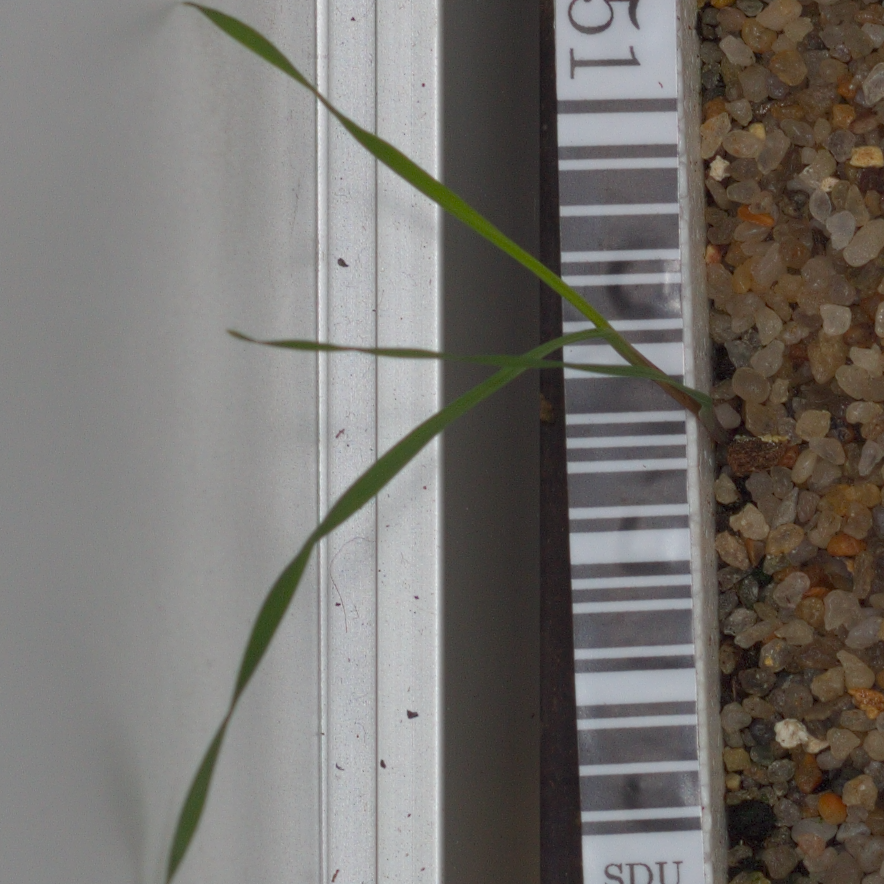

In [4]:
from IPython.display import Image
Image('/content/gdrive/My Drive/seedling/train/Black-grass/4a7e7eba8.png')

In [0]:
def get_data(batch_size,image_size,path='/content/gdrive/My Drive/seedling/'):
  
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
  
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization
    ])
    
    dataset_train = datasets.ImageFolder(os.path.join(path,'train'),transform = transform)
    dataset_test = datasets.ImageFolder(os.path.join(path,'test'),transform = transform)
    
    dataloader_train = torch.utils.data.DataLoader(dataset = dataset_train,batch_size = batch_size,shuffle=True)  
    dataloader_test = torch.utils.data.DataLoader(dataset = dataset_test,batch_size = batch_size,shuffle=True)  
    
    return dataloader_train,dataloader_test
  
data_train,data_test = get_data(128,224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)
torch.Size([128])


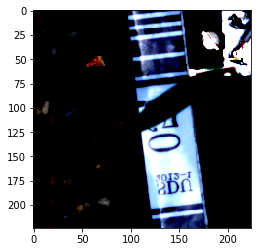

In [6]:
for idx,(data,label) in enumerate(data_train):
  if idx == 1 :
    print(label[3])
    print(np.shape(label))
    npimg = data[3].numpy()
    plt.imshow(np.transpose(npimg))
    break

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    
    self.conv1 = nn.Conv2d( 3, 32, 3, stride = 2, padding = 1)
  
    self.conv2 = nn.Conv2d( 32, 64, 3, stride = 2, padding = 1)
 
    self.conv3 = nn.Conv2d( 64, 128, 3, padding = 1)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear( 128*7*7, 512)
    
    self.fc2 = nn.Linear( 512, 12)
    
    self.dp = nn.Dropout( p=0.3)
    
  def forward( self, x):
    
    x = self.pool( F.relu(self.conv1(x)))
    
    x = self.pool( F.relu(self.conv2(x)))
    
    x = self.pool( F.relu(self.conv3(x)))
    
    x = x.view( -1, 128*7*7)
     
    x = self.dp( x)
    
    x = F.relu( self.fc1(x))
    
    x = self.dp( x)
    
    out = self.fc2( x)
    
    return out
  

In [9]:
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [0]:
model = CNN()

if use_cuda:
  model = model.cuda()

In [11]:
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12, bias=True)
  (dp): Dropout(p=0.3)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [0]:
def train(epochs,loaders,model,optimizer,criterion,use_cuda,path):
  
  for epoch in range(0,epochs+1):
    
    train_loss = 0.0
    
    model.train()
    
    for idx,(data,target) in enumerate(loaders):
      
      if use_cuda :
        
        data = data.cuda()
        target = target.cuda()
        
      optimizer.zero_grad()
      
      output = model(data)
      
      loss = criterion(output,target)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss = train_loss + ((1 / (idx +1)) * (loss.data - train_loss))
      
      if idx % 4 == 0:
        print('Epoch %d,Batch %d,Loss %.6f'% (epoch,idx+1,train_loss))
        
      if epoch % 5 == 0:
        torch.save(model.state_dict(),path)
        
  return model

In [14]:
epochs = 50

model.cuda()

path = 'seedling.pt'

train(epochs,data_train,model,optimizer,criterion,use_cuda,path)

model.load_state_dict(torch.load(path))

Epoch 0,Batch 1,Loss 2.483582
Epoch 0,Batch 5,Loss 2.466230
Epoch 0,Batch 9,Loss 2.448621
Epoch 0,Batch 13,Loss 2.431819
Epoch 0,Batch 17,Loss 2.414925
Epoch 0,Batch 21,Loss 2.406924
Epoch 0,Batch 25,Loss 2.403684
Epoch 0,Batch 29,Loss 2.399320
Epoch 0,Batch 33,Loss 2.396877
Epoch 1,Batch 1,Loss 2.396359
Epoch 1,Batch 5,Loss 2.354071
Epoch 1,Batch 9,Loss 2.338445
Epoch 1,Batch 13,Loss 2.337355
Epoch 1,Batch 17,Loss 2.333566
Epoch 1,Batch 21,Loss 2.321265
Epoch 1,Batch 25,Loss 2.319383
Epoch 1,Batch 29,Loss 2.315387
Epoch 1,Batch 33,Loss 2.311102
Epoch 2,Batch 1,Loss 2.290790
Epoch 2,Batch 5,Loss 2.275742
Epoch 2,Batch 9,Loss 2.270934
Epoch 2,Batch 13,Loss 2.254990
Epoch 2,Batch 17,Loss 2.239746
Epoch 2,Batch 21,Loss 2.222020
Epoch 2,Batch 25,Loss 2.205076
Epoch 2,Batch 29,Loss 2.186032
Epoch 2,Batch 33,Loss 2.163694
Epoch 3,Batch 1,Loss 2.024766
Epoch 3,Batch 5,Loss 1.950164
Epoch 3,Batch 9,Loss 1.914495
Epoch 3,Batch 13,Loss 1.917943
Epoch 3,Batch 17,Loss 1.912241
Epoch 3,Batch 21,Los

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
def test(loaders,model,criterion,use_cuda):
  
  test_loss = 0.
  correct = 0.
  total = 0.
  
  model.eval()
  
  for idx, (data,target) in enumerate(loaders):
    
    if use_cuda:
      
      data = data.cuda()
      target = target.cuda()
      
    output = model(data)
    
    loss = criterion(output,target)
    
    test_loss = test_loss + ((1 / (idx +1)) * (loss.data - test_loss))
    
    pred = output.data.max(1, keepdim=True)[1]
    
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        
    total += data.size(0)
    
  print('Test Loss: %.6f\n'%(test_loss))

  print('Test Accuracy: %2d%% (%2d/%2d)' % ((100. * correct/total),correct,total))

In [16]:
model.cuda()

test(data_test,model,criterion,use_cuda)

Test Loss: 0.755416

Test Accuracy: 74% (416/555)


In [0]:
def get_pred_data(batch_size, image_size, path='/content/gdrive/My Drive/seedling/'):
  
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
  
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization
    ])
    
    dataset_pred = datasets.ImageFolder(os.path.join(path,'pred'),transform = transform)
    
    dataloader = torch.utils.data.DataLoader(dataset = dataset_pred,batch_size = batch_size,shuffle=True)  
    
    
    return dataloader
  
dataloader = get_pred_data(1,224)

In [0]:
def pred(loader, model, use_cuda):
  
  model.eval()
  
  preds= []
  
  for idx, (data, _) in enumerate(loader):
    
    if use_cuda:
      
      data = data.cuda()
      
    output = model(data)
    
    output.size()
    
    pred = output.data.max( 1, keepdim = True)[1]
    
    pred = pred.cpu().numpy()
    
    preds.append(pred)
    
  return preds
  

In [0]:
out = pred(dataloader, model, use_cuda)

In [36]:
out

[array([[1]]),
 array([[10]]),
 array([[11]]),
 array([[6]]),
 array([[8]]),
 array([[8]]),
 array([[6]]),
 array([[1]]),
 array([[3]]),
 array([[4]]),
 array([[10]]),
 array([[1]]),
 array([[3]]),
 array([[6]]),
 array([[5]]),
 array([[11]]),
 array([[3]]),
 array([[6]]),
 array([[10]]),
 array([[3]]),
 array([[9]]),
 array([[11]]),
 array([[3]]),
 array([[8]]),
 array([[2]]),
 array([[1]]),
 array([[3]]),
 array([[6]]),
 array([[5]]),
 array([[8]]),
 array([[5]]),
 array([[6]]),
 array([[5]]),
 array([[1]]),
 array([[8]]),
 array([[3]]),
 array([[3]]),
 array([[6]]),
 array([[6]]),
 array([[8]]),
 array([[1]]),
 array([[5]]),
 array([[11]]),
 array([[1]]),
 array([[1]]),
 array([[6]]),
 array([[2]]),
 array([[5]]),
 array([[3]]),
 array([[8]]),
 array([[10]]),
 array([[11]]),
 array([[6]]),
 array([[4]]),
 array([[3]]),
 array([[9]]),
 array([[1]]),
 array([[6]]),
 array([[10]]),
 array([[3]]),
 array([[4]]),
 array([[0]]),
 array([[6]]),
 array([[10]]),
 array([[2]]),
 array([[3]]),

In [35]:
len(out)

794